# Active Learning

## Imports

In [79]:
import numpy as np           
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.layers import Input, Conv1D, Dropout, Flatten, Dense, MaxPooling1D
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from modAL.models import ActiveLearner
import matplotlib as mpl
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


## Data Preprocessing

In [180]:
# Constants
#FILE_PATHS = [r'New data\test_data.csv', r'New data\test_label.csv', r'New data/train_data.csv', r'New data/train_label.csv']
FILE_PATHS = [r'test_data.csv', r'test_label.csv', r'train_data.csv', r'train_label.csv']
x_train = pd.read_csv(FILE_PATHS[2])
y_train = pd.read_csv(FILE_PATHS[3])
x_test = pd.read_csv(FILE_PATHS[0])
y_test = pd.read_csv(FILE_PATHS[1])
performance = pd.read_csv('performance.csv', header=None).to_numpy()
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)

x_train, y_train = shuffle(x_train, y_train, random_state=45)
#x_test, y_test = shuffle(x_test, y_test, random_state=5)

# assemble initial data
n_initial = 40
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)




## Data Preprocessing (480)

## CNN Model

In [178]:

def create_model():
    model = Sequential()
    model.add(Input(shape=(1000, 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(80, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    model.compile( optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#save the model
model = create_model()


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             shuffle=True,
                             batch_size=32,
                             epochs=20,
                             verbose=1,
                             validation_split=0.3)


### DL Model Evaluation 

In [ ]:
#model.fit(x_train, y_train,epochs=40, validation_split=0.3, shuffle=True,batch_size=32,verbose=1)
classifier.fit(x_train, y_train)

In [ ]:
loss, accuracy= model.evaluate(x_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))
print('Loss: %.2f' % (loss))


In [ ]:
print(classifier.score(x_test,y_test))
y_pred = classifier.predict(x_test).argmax(axis=1)
y_test1 = y_test.argmax(axis=1)
print(confusion_matrix(y_test1, y_pred))

## Active Learning Cycle

In [82]:
# initialize ActiveLearner
learner = ActiveLearner(estimator=classifier,
                        X_training=x_initial,
                        y_training=y_initial,
                        verbose=0)
unqueried_score = learner.score(x_test,y_test)
unqueried_recall = learner.score(x_test,y_test,)
print(unqueried_score)
performance_history = [unqueried_score]
current_epochs = 12
current_batch_size=10
n_queries = 11
# the active learning loop
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(x_pool,n_instances=40)

    queried_x = x_pool[query_idx]
    queried_y = y_pool[query_idx]
    
    
    learner.teach(
    X=queried_x, 
    y=queried_y,
    verbose=0,
    epochs=current_epochs, 
    batch_size=current_batch_size,
    validation_split=0.3 
            )
    

    # remove queried instance from pool
    x_pool = np.delete(x_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)


    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(x_test,y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    # Increment the number of epochs for the next query
    current_epochs += 2
    current_batch_size+=1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.3333333333333333
Query no. 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy after query 1: 0.4033
Query no. 2
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Accuracy after query 2: 0.4867
Query no. 3
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy after query 3: 0.4667
Query no. 4
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy after query 4: 0.5167
Query no. 5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy after query 5: 0.5600
Query no. 6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy after query 6: 0.8867
Query no. 7
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy after query 7: 0.7567
Query no. 8
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms

### Model Evaluation

In [83]:
y_pred = learner.predict(x_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


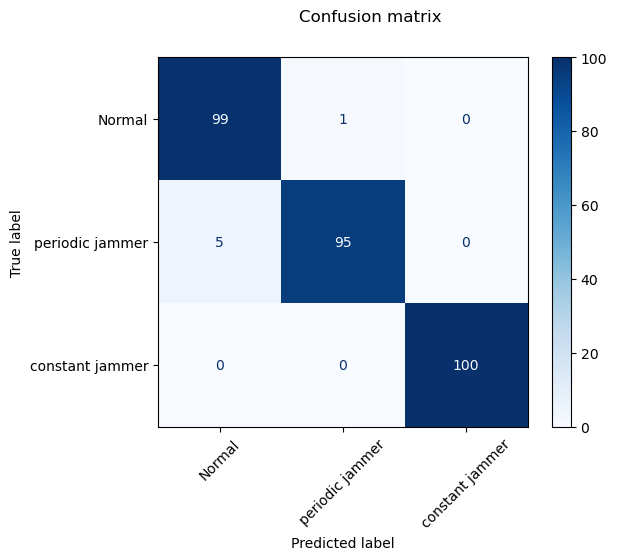

In [87]:

class_names = ['Normal','periodic jammer', 'constant jammer']
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plo
display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                  display_labels=class_names,
                                                  cmap='Blues',
                                                  xticks_rotation=45)
display.figure_.suptitle(title)
plt.show()

In [85]:
print(classification_report(y_true, y_pred, target_names=class_names))


                 precision    recall  f1-score   support

         Normal       0.95      0.99      0.97       100
periodic jammer       0.99      0.95      0.97       100
constant jammer       1.00      1.00      1.00       100

       accuracy                           0.98       300
      macro avg       0.98      0.98      0.98       300
   weighted avg       0.98      0.98      0.98       300



## Active Learning Cycle (monte carlo)

In [ ]:
for i in range(20):

      # initialize ActiveLearner
      learner = ActiveLearner(estimator=classifier,
                              X_training=x_initial,
                              y_training=y_initial,
                              verbose=0)
      unqueried_score = learner.score(x_test,y_test)
      print(unqueried_score)
      performance_history = [unqueried_score]
      current_epochs = 12
      current_batch_size=10
      n_queries = 15


      # the active learning loop
      for idx in range(n_queries):
            print('Query no. %d' % (idx + 1))
            query_idx, query_instance = learner.query(x_pool,n_instances=30)

            queried_x = x_pool[query_idx]
            queried_y = y_pool[query_idx]
            
            
            learner.teach(
            X=queried_x, 
            y=queried_y,
            verbose=0,
            epochs=current_epochs, 
            batch_size=current_batch_size,
            validation_split=0.3 
                  )
            
      
            # remove queried instance from pool
            x_pool = np.delete(x_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx, axis=0)

      
            # Calculate and report our model's accuracy.
            model_accuracy = learner.score(x_test,y_test)
            print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
            # Save our model's performance for plotting.
            performance_history.append(model_accuracy)
            # Increment the number of epochs for the next query
            current_epochs += 2
            current_batch_size+=1
      performance[i+34] = np.array(performance_history).reshape(1, len(performance_history))    
      #save as csv
      pd.DataFrame(performance).to_csv('performance.csv', index=False, header=False)
      print("saved")# assemble initial data
      initial_idx = np.random.choice(range(len(x_train)),
                                    size=n_initial,
                                    replace=False)
      x_initial = x_train.iloc[initial_idx]
      y_initial = y_train[initial_idx]
      x_initial = x_initial.to_numpy()

      # generate the pool
      # remove the initial data from the training dataset
      x_pool = np.delete(x_train, initial_idx, axis=0)
      y_pool = np.delete(y_train, initial_idx, axis=0)  
    

### Model Evaluation (monte carlo)

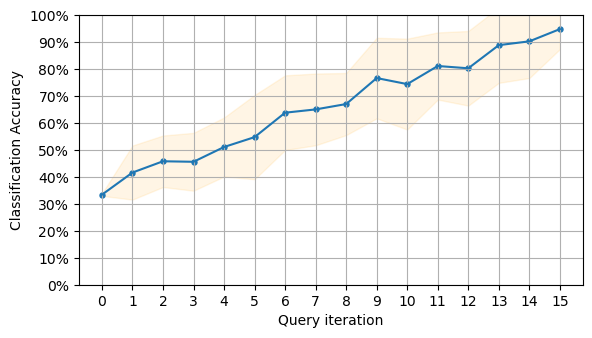

In [91]:
performance = pd.read_csv('performance.csv', header=None)
means = performance.mean()
stds = performance.std()
plt.style.use('default')
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6.5, 3.5))
ax.plot(means)
ax.fill_between(range(len(means)), means-stds, means+stds, alpha=0.1, color='orange')
ax.scatter(range(len(means)), means, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=16, integer=True, min_n_ticks=16))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)
#ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
plt.show()
#save the plot
fig.savefig('AL.png')